In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

torch.cuda.empty_cache()


In [4]:
setting, num_user = "FedAvg_adv", 40

try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user,  experiment = "cifar10")

# Load models for FAT and FedAvg
save_path_FAT = 'weights/cifar10/230922_baseline_train/FAT/'
save_path_FedAvg = 'weights/cifar10/230922_baseline_train/fedavg/'
# save_path_FAT_sub_label = 'weights/cifar10/fat2/240917_subset_label_v2_G05/FAT/'
# save_path_FAT_sub_label = 'weights/cifar10/fat2/240920_subset_label_transfer_G05/FAT/'
save_path_FAT_sub_label = 'weights/cifar10/fat2/241011_subset_label_targeted_G05/FAT/'

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = copy.deepcopy(import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0])
model_FAT_sub_label = import_model_weights(num_user, setting, save_path_FAT_sub_label, aggregator, args_)[0]

In [5]:
# Perform transfer attack from one client to another and record stats
# models_test = [model_Fedavg, model_FAT]

models_test = [model_Fedavg, model_FAT, model_FAT_sub_label]

num_trials = 1
acc_store_agg = np.zeros([len(models_test)])
adv_store_agg = np.zeros([len(models_test)])

# for itt in range(num_trials):

# Run Measurements for both targetted and untargeted analysis
victim_idxs = range(len(models_test))
logs_adv = generate_logs_adv(len(models_test))
custom_batch_size = 100
eps = 3

dataloader = load_client_data(clients = clients, c_id = 0, mode = 'all') # or test/train

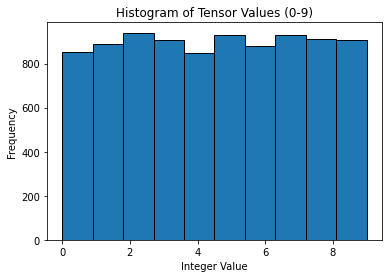

In [6]:
dataloader.y_data

# Convert tensor to numpy array for plotting
values = dataloader.y_data.numpy()

# Create histogram
plt.hist(values, bins=10, range=(0, 9), edgecolor='black')

# Add labels and title
plt.xlabel('Integer Value')
plt.ylabel('Frequency')
plt.title('Histogram of Tensor Values (0-9)')

# Show plot
plt.show()

In [7]:
non_target_labels= [0,1,2,3,4]
target_labels = [5,6,7,8,9]

logs_adv_target = copy.deepcopy(logs_adv)
logs_adv_non_target = logs_adv

cross_attack_target(logs_adv_target, victim_idxs, dataloader, models_test, 
                        target_labels, custom_batch_size=500, eps=4.5, atk_steps=10)

metrics = ['orig_acc_transfers','orig_similarities','adv_acc_transfers','adv_similarities_target',
            'adv_similarities_untarget','adv_target','adv_miss']

adv_miss = get_metric_list("adv_miss", logs_adv_target, victim_idxs)
acc = get_metric_list("orig_acc_transfers", logs_adv_target, victim_idxs)

# Print along diagonal and plot "robustness against white-box attacks (self)"
adv_list_target = []
acc_list_target = []
for i in range(adv_miss.shape[0]):
    adv_list_target += [adv_miss[i,i]]
    acc_list_target += [acc[i,i]]
    

cross_attack_target(logs_adv_non_target, victim_idxs, dataloader, models_test, 
                        non_target_labels, custom_batch_size=500, eps=4.5, atk_steps=10)

adv_miss = get_metric_list("adv_miss", logs_adv_non_target, victim_idxs)
acc = get_metric_list("orig_acc_transfers", logs_adv_non_target, victim_idxs)

# Print along diagonal and plot "robustness against white-box attacks (self)"
adv_list_ntarget = []
acc_list_ntarget = []
for i in range(adv_miss.shape[0]):
    adv_list_ntarget += [adv_miss[i,i]]
    acc_list_ntarget += [acc[i,i]]

	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2


In [8]:
print("### Non Targets 0-4 ###")
print("[model_Fedavg, model_FAT, model_FAT_sub_label]")
print("Test Acc:", acc_list_ntarget)
print("Adv  Acc:", adv_list_ntarget)


print("\n### Targets 5-9 ###")
print("[model_Fedavg, model_FAT, model_FAT_sub_label]")
print("Test Acc:", acc_list_target)
print("Adv  Acc:", adv_list_target)

### Non Targets 0-4 ###
[model_Fedavg, model_FAT, model_FAT_sub_label]
Test Acc: [0.8122605085372925, 0.7659574151039124, 0.8192770481109619]
Adv  Acc: [0.003937007859349251, 0.3410852551460266, 0.0043668122962117195]

### Targets 5-9 ###
[model_Fedavg, model_FAT, model_FAT_sub_label]
Test Acc: [0.8920000195503235, 0.8253968954086304, 0.8167939186096191]
Adv  Acc: [0.016129031777381897, 0.40833336114883423, 0.12903225421905518]
